### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Friday, Feb 19th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

#1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

#?2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

?3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

#4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

#5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

#6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

#7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

#8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

?9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [91]:
!pip install numdifftools
!pip install corner

### Solution

In [295]:
# IMPORTS
##########
##########
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import norm
from scipy.stats import laplace
import seaborn as sns
import corner
%matplotlib inline

# CODE
#######
#######

#CLD loading in the data with np.load
placeholder = np.load('../../../coursework/homeworks/hw_data/hw3_data_1.npy')

#CLD seperating the data and the associated uncert for ease of manipulation ie i dont want to think about indexing
data = placeholder[:,0]
uncert = placeholder[:,1]

#CLD from lecture 5 using the sample mean equation for heterodescadstic gaussian
sample_mean = np.sum(data / (uncert**2)) / np.sum(1/(uncert**2))

#CLD from same lecutre using the formula for std on sample mean
std_sample_mean = 1 / np.sqrt(np.sum(1/(uncert**2)))

print('This samples mean: '+str(sample_mean))
print('The standard error on this sample mean: '+str(std_sample_mean))
print("")

#CLD using the same technique as was established in lecture 6 but instead finding the best fit sample mean from the 
#CLD log likelihood function
#CLD establishing the log likelihood function
def lnL_hetero(mean_guess, y, sig):
    return np.sum((y-mean_guess)**2/(sig**2), -1)

#CLD creating a second function that runs it changing mu?
f_lnL_hetero = lambda mu: lnL_hetero(mu, 
                                      y=data, sig=uncert)
#CLD optimizing it to find the best sample mean
mu = 4
mu_squared = optimize.fmin(f_lnL_hetero, mu)

print('The fitted mu: '+str(mu_squared[0]))
print("")

#CLD creating pdf to use for the fisher estimate
mugrid = np.linspace(1,8,1000)
L_scan = []
for mu in mugrid:
    L = norm.logpdf(data, mu, uncert)
    L = np.sum(L)
    L_scan.append(L)
    
L_scan = np.array(L_scan)

#CLD to use the numerical technique to find the fisher uncert on the mean, first take the second deravitive of lnL
sigma_mu = np.diff(L_scan, n=2)

#CLD divide through by delta_parameter^2 for normalization
sigma_mu /= (mugrid[1]-mugrid[0])**2

#CLD multiply by negative 1
sigma_mu *= -1

#CLD finally, take the square root. As we defined by the difference in the first set of parameters, will only be 
#looking at the first element of sigma_mu?
sigma_mu = 1/(np.sqrt(sigma_mu))[0]

print('The calculated Fisher estimate uncertaintiy is: '+str(sigma_mu))
print("")

#CLD writing the Laplace minimization function
#CLD essentially the same except this time fitting for mu and what would be sig but is the scale parameter
def lnL_laplace(loc_guess, scale_guess, y):
    p = laplace.logpdf(y, loc_guess, scale_guess)
    p = np.sum(p)
    return -p

f_lnL_laplace = lambda omega: lnL_laplace(omega[0], omega[1],
                                        y=data)
omega = [3,0.2]
omega_fit = optimize.fmin(f_lnL_laplace, omega)

print('The fitted location parameter for the Laplace function: '+str(omega_fit[0]))
print('The fitted scale parameter for the Laplace function: '+str(omega_fit[1]))

#CLD computing the AIC for both models
k_guass = 1 #fitting one parameter 
n = np.size(data)
aic_guass = -2*(-lnL_hetero(mu_squared, data, uncert)) + (2*k_guass) + ((2*k_guass*(1+k_guass))/(n - k_guass - 1))

k_laplace = 1 #fitting two parameters
aic_laplace = -2*(-lnL_laplace(omega_fit[0], omega_fit[1],  data)) + (2*k_laplace) + ((2*k_laplace*(1+k_laplace))/(n - k_laplace - 1))

print('\nThe AIC for the guassian model: '+str(aic_guass))
print('The AIC for the Laplacian model: '+str(aic_laplace))
print('Based on the calculated AIC values, the heteroscedastic gaussian model is the better fit.')


This samples mean: 3.9179920346060557
The standard error on this sample mean: 0.09481084100510956

Optimization terminated successfully.
         Current function value: 86.325091
         Iterations: 12
         Function evaluations: 24
The fitted mu: 3.91796875

The calculated Fisher estimate uncertaintiy is: 0.09481084100292582

Optimization terminated successfully.
         Current function value: 156.788916
         Iterations: 67
         Function evaluations: 122
The fitted location parameter for the Laplace function: 4.081268817368361
The fitted scale parameter for the Laplace function: 0.8822692393980376

The AIC for the guassian model: 174.69099783302718
The AIC for the Laplacian model: 315.6186486797107
Based on the calculated AIC values, the heteroscedastic gaussian model is the better fit.


In [277]:
#CLD writing the bootstrap funciton
#CLD to bootstrap, draw random samples equal in size to the original dataset from the original dataset N times
#CLD in bootstrapping, you may redraw values
#CLD then calculate whatever statistic you are interested in investigating
#CLD this maps out uncertainity distributions in our statistics
def bootstrap(y, dy, N):
    #CLD creating empty array to store the calculated vaules in
    means = np.array([])
    loc = np.array([])
    scale = np.array([])
    
    #CLD looping over N
    for i in range(N):
        #CLD creating fascimile "draws" by randomly creating an array of indices which should correspond
        #to elements in the data. as it is ok to redraw, do not need to worry about repeat indices
        sample_ind = np.random.randint(np.size(y), size=np.size(y))
        sample_data = y[sample_ind]
        sample_uncert = dy[sample_ind]
        
        #CLD calculating best fit mean for these bootstrap realizations
        #CLD first for guassian and then for Laplace distributions
        f_lnL_hetero = lambda mu: lnL_hetero(mu, 
                                      y=sample_data, sig=sample_uncert)
        mu = 4
        mu_fit = optimize.fmin(f_lnL_hetero, mu, disp=False) #CLD disp=False supresses output
        means = np.append(means, mu_fit)
        
        f_lnL_laplace = lambda omega: lnL_laplace(omega[0], omega[1],
                                                 y=sample_data)
        params = [3,0.2]
        params_fit = optimize.fmin(f_lnL_laplace, params, disp=False)
        loc = np.append(loc, params_fit[0])
        scale = np.append(scale, params_fit[1])
            
    return means, loc, scale


In [278]:
#CLD running bootstrap code
bootstrap_means, bootstrap_locs, bootstrap_scales = bootstrap(data, uncert, 1000)

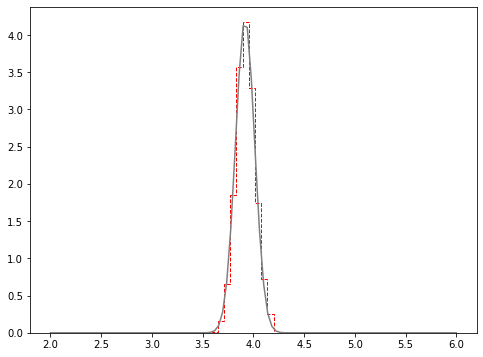

The sample mean and sample mean distribution found in step one does agree with that found through bootstrapping


In [279]:
#CLD creating a pdf based off of found sig and mean from (1)
xgrid = np.linspace(2,6,100)
distG = norm(sample_mean, std_sample_mean)
distG_pdf = distG.pdf(xgrid)

#CLD plotting the normalized histograms of means along with pdf based on found mean and sig
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(bootstrap_means, density=True, histtype='step', ls='dashed', color='r')
ax.plot(xgrid, distG_pdf, c='grey');
plt.show()

print('The sample mean and sample mean distribution found in step one does agree with that found through bootstrapping')


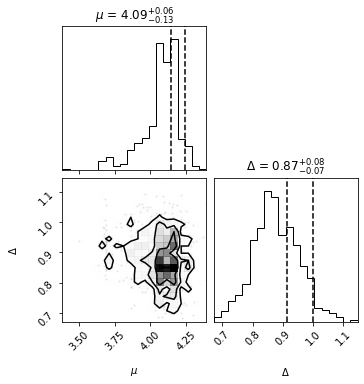

In [280]:
ndim, nsamples = 1, 1000
corner_data = np.hstack([bootstrap_locs.reshape([nsamples, ndim]), bootstrap_scales.reshape([nsamples, ndim])])
figure = corner.corner(corner_data, labels=[r'$\mu$', r'$\Delta$'], quantiles=[0.68, 0.95], show_titles=True)

In [294]:
import numdifftools as nd
H = nd.Hessian(f_lnL_laplace)([omega_fit[0], omega_fit[1]])
sigma_laplace = np.linalg.inv(H)**0.5
print(sigma_laplace)
print('Based on the error ranges given above, the off diagonal elements seem to be consistent with previous calculations')


[[0.09250326        nan]
 [       nan 0.08823044]]
Based on the error ranges given above, the off diagonal elements seem to be consistent with previous calculations


<ipython-input-294-afa5724f8300>:3: RuntimeWarning: invalid value encountered in sqrt
  sigma_laplace = np.linalg.inv(H)**0.5
